# Predicting Wine Prices with Machine Learning 🍷

## Project Description

In this project, I aimed to predict the price 💰 of Bordeaux wines 🍷 based on various features such as rating, volume, and other relevant characteristics. The dataset used, the **21st Century Bordeaux Wine Dataset** from Kaggle, contains valuable information about 14,349 wines, which was used to build a predictive machine learning model.

To achieve this, I selected the **ElasticNet** regression model, which combines the strengths of both **Ridge** and **Lasso** regression techniques. ElasticNet is particularly useful when dealing with multiple features and potential multicollinearity. I also implemented **Grid Search** to optimize the model's hyperparameters, ensuring that the model achieves the best possible performance.

Source of the dataset: [21st Century Bordeaux Wine Dataset on Kaggle](https://www.kaggle.com/datasets/mexwell/21st-century-bordeaux-wine-dataset/data)

## Steps Taken

### 1. Data Import and Cleaning

	• First, the dataset was loaded and a copy was created.
	• The ‘Price’ column contained some missing or invalid values (e.g., “$NA”).
    These rows were dropped, and the ‘Price’ column was cleaned by removing unnecessary characters like ‘ml’ and ‘$’. 
	• After cleaning, the ‘Volume’ column was created by extracting the volume from the ‘Price’ values (in case the price was provided for different volumes such as 27/375 ml).
	• I also created additional features, such as ‘Price_per_ml’ and ‘Price_per_750ml’, to better understand the wine prices at different volumes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset

df_original = pd.read_csv('BordeauxWines.csv')

# Creating a copy of the original dataframe for further processing
df = df_original.copy()

df.head()

,Name,Year,Score,Price,BLOOD ORANGE,CITRUS,CITRUS PEEL,CITRUS ZEST,CLEMENTINE,LIME,...,SKUNK,SULFUR DIOXIDE,"WET WOOL,WET DOG",ACETIC ACID,ETHANOL,ETHYL ACETATE,ALCOHOL,FROTH,MENTHOL,SHERRY
0,ChÃ¢teau Croix Figeac St.-Emilion,2008,84,$20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ChÃ¢teau Fonroque St.-Emilion,2008,84,$29,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ChÃ¢teau Grand Bertin de St.-Clair MÃ©doc,2008,84,$NA,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ChÃ¢teau Lion Beaulieu Bordeaux White,2008,84,$NA,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ChÃ¢teau Marsau CÃ´tes de Francs,2008,84,$20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14349 entries, 0 to 14348
Columns: 989 entries, Name to SHERRY
dtypes: int64(987), object(2)
memory usage: 108.3+ MB


In [4]:
# Dropping rows with unknown prices and converting 'Price' column to numeric values

df = df[~df['Price'].str.contains(r'\$NA', na=False)]

# Removing 'ml' and '$' from the 'Price' column to clean the data

df['Price'] = df['Price'].str.replace('ml', '', regex=False)
df['Price'] = df['Price'].str.replace('$', '', regex=False)

In [5]:
# Extracting volume information from the 'Price' column (if available)

df['Volume'] = df['Price'].apply(lambda x: x.split('/')[1] if '/' in x else np.nan).astype(float)
df['Price'] = df['Price'].str.replace(r'/.*', '', regex=True).astype(float)

In [6]:
# Filling missing volume values with the default volume (750 ml)

df['Volume'] = df['Volume'].fillna(750)

# Checking unique volume values to ensure correct transformation

df['Volume'].unique()

array([750., 375., 500.])

In [7]:
# Calculating price per milliliter and price per 750ml

df['Price_per_ml'] = df['Price'] / df['Volume']
df['Price_per_750ml'] = df['Price_per_ml'] * 750

In [8]:
# Dropping the 'Name' column as it is not required for prediction

df = df.drop(columns=['Name'])

### 2. Exploratory Data Analysis (EDA)

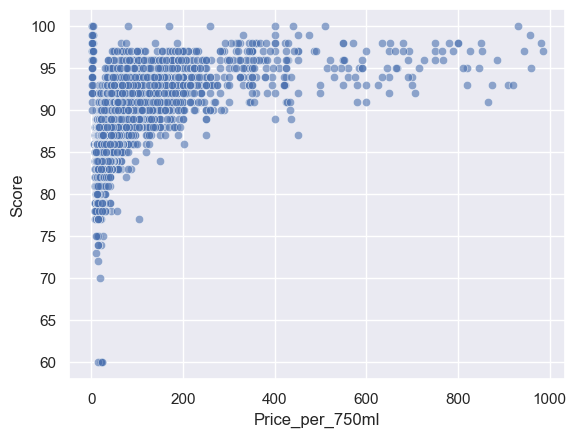

In [9]:
# Creating a scatter plot to visualize the relationship between 
# price per 750ml and wine score

sns.set(style='darkgrid')
sns.scatterplot(x='Price_per_750ml', y='Score', data=df, alpha=0.6);

### 	3.	Feature Selection and Scaling
	• The dataset was split into features (X) and the target variable (y, which is the wine Price per 750ml).
	• The data was then divided into training and testing sets using a 70/30 split for validation purposes.
	• Data scaling was applied using StandardScaler to ensure that the model could perform optimally, especially for algorithms sensitive to the scale of the input features.

In [10]:
# Preparing features (X) and target (y) for the model

X = df.drop('Price_per_750ml',axis=1)
y = df['Price_per_750ml']

# Splitting the data into training and testing sets (70% training, 30% testing)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scaling the data to standardize the features

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### 	4.	Modeling with ElasticNet
	• ElasticNet, a regularized regression model, was chosen for this task. I used GridSearchCV to perform hyperparameter tuning and find the best values for alpha and l1_ratio.
	• After training the model, I evaluated its performance using Mean Squared Error (MSE) and Root Mean Squared Error (RMSE).

In [11]:
# Creating an ElasticNet model for regression

from sklearn.linear_model import ElasticNet

base_elastic_model = ElasticNet()

# Defining the hyperparameters for GridSearchCV to find the best model

param_grid = {'alpha':[0.09, 0.1], 'l1_ratio':[.03, .05, .07,.1]}

In [12]:
# Using GridSearchCV to find the best hyperparameters based on cross-validation

from sklearn.model_selection import GridSearchCV

grid_model = GridSearchCV(estimator=base_elastic_model, param_grid=param_grid, 
                          scoring='neg_mean_squared_error', cv=5, verbose=0)
grid_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.09, 0.1],
                         'l1_ratio': [0.03, 0.05, 0.07, 0.1]},
             scoring='neg_mean_squared_error')

In [13]:
# Getting the best estimator (model) from GridSearchCV

grid_model.best_estimator_

ElasticNet(alpha=0.09, l1_ratio=0.1)

In [14]:
# Making predictions on the test set

y_pred = grid_model.predict(X_test)

## Visualization & Model Performance

R-squared Score: 0.995
Mean Absolute Error: 2.282
Root Mean Squared Error: 5.741

Performance by Price Range:
price_range
(0.056, 189.8]     1.653732
(189.8, 378.6]     9.348368
(378.6, 567.4]    26.332929
(567.4, 756.2]    39.981324
(756.2, 945.0]    41.890883
Name: abs_error, dtype: float64


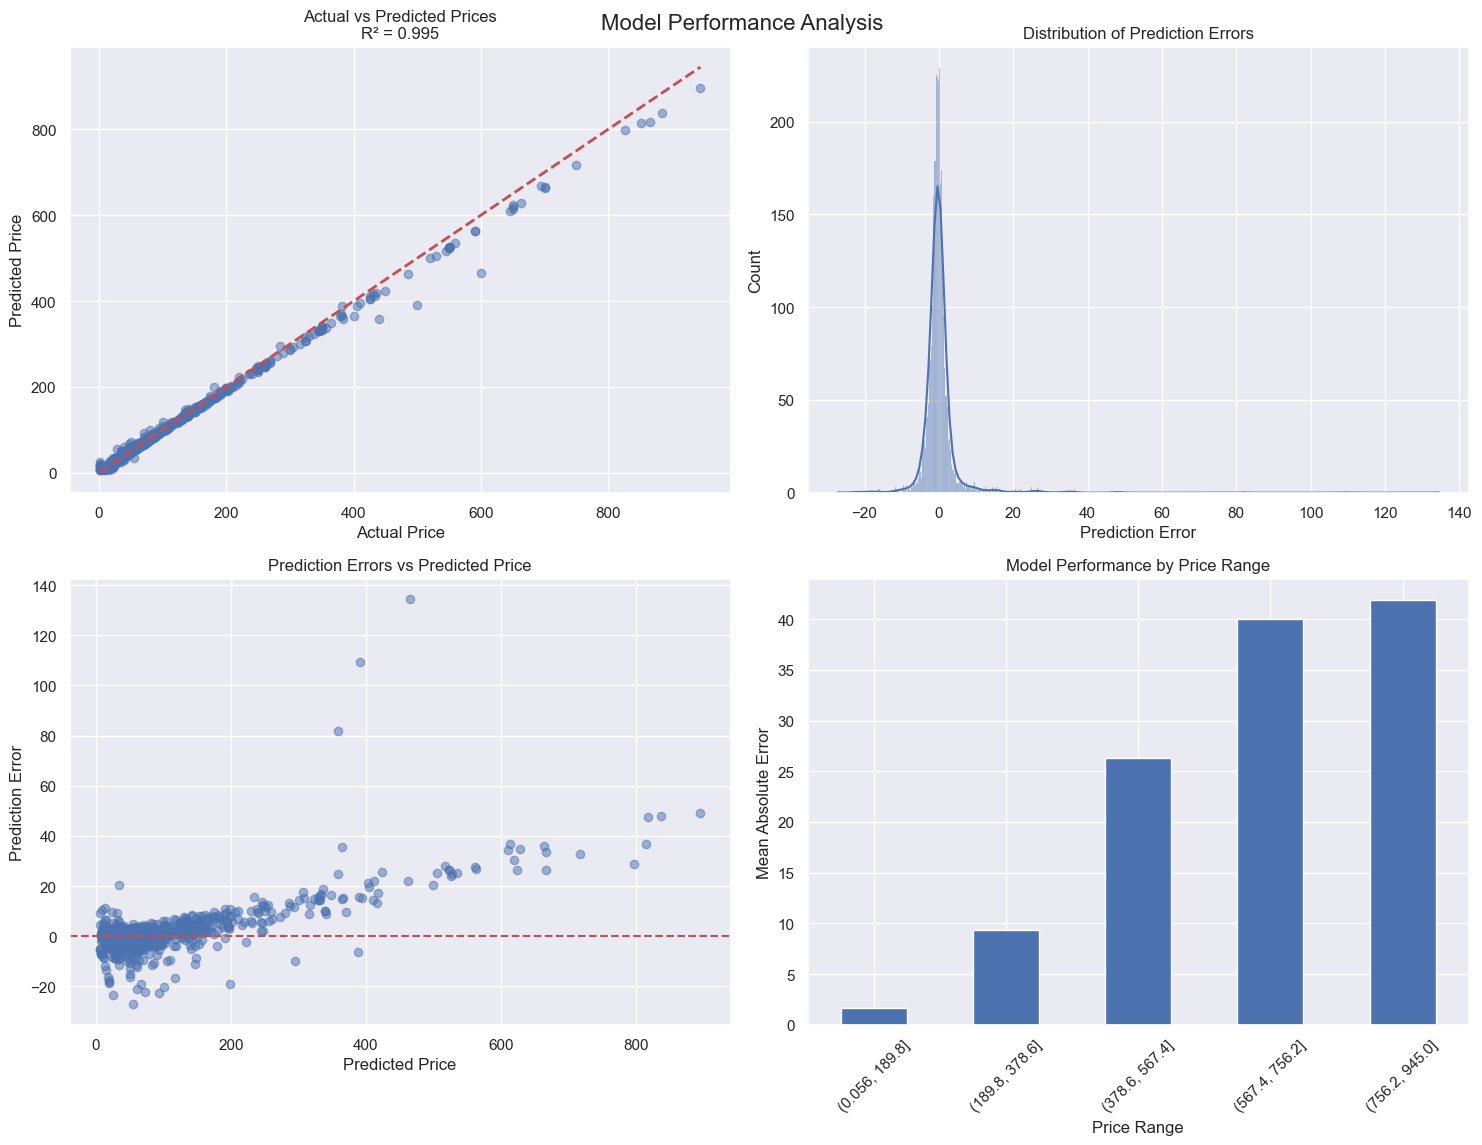

In [25]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

def analyze_model_performance(y_test, y_pred):
    # Calculate R-squared
    r2 = r2_score(y_test, y_pred)
    
    # Calculate RMSE
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Calculate prediction errors
    errors = y_test - y_pred
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Model Performance Analysis', fontsize=16, y=0.95)
    
    # 1. Prediction vs Actual Scatter Plot
    axes[0,0].scatter(y_test, y_pred, alpha=0.5)
    axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0,0].set_xlabel('Actual Price')
    axes[0,0].set_ylabel('Predicted Price')
    axes[0,0].set_title(f'Actual vs Predicted Prices\nR² = {r2:.3f}')
    
    # 2. Error Distribution
    sns.histplot(errors, kde=True, ax=axes[0,1])
    axes[0,1].set_xlabel('Prediction Error')
    axes[0,1].set_ylabel('Count')
    axes[0,1].set_title('Distribution of Prediction Errors')
    
    # 3. Error vs Predicted Value
    axes[1,0].scatter(y_pred, errors, alpha=0.5)
    axes[1,0].axhline(y=0, color='r', linestyle='--')
    axes[1,0].set_xlabel('Predicted Price')
    axes[1,0].set_ylabel('Prediction Error')
    axes[1,0].set_title('Prediction Errors vs Predicted Price')
    
    # 4. Performance by Price Range
    price_ranges = pd.cut(y_test, bins=5)
    mae_by_range = pd.DataFrame({
        'price_range': price_ranges,
        'abs_error': abs(errors)
    }).groupby('price_range')['abs_error'].mean()
    
    mae_by_range.plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_xlabel('Price Range')
    axes[1,1].set_ylabel('Mean Absolute Error')
    axes[1,1].set_title('Model Performance by Price Range')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    
    # Print additional metrics
    print(f"R-squared Score: {r2:.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.3f}")
    print(f"Root Mean Squared Error: {RMSE:.3f}")
    print("\nPerformance by Price Range:")
    print(mae_by_range)
    
    return fig, mae_by_range

# Run the analysis
fig, mae_by_range = analyze_model_performance(y_test, y_pred)
plt.show()

### Conclusion

The ElasticNet model demonstrates excellent performance in predicting Bordeaux wine prices:

    ✅ R-squared score of 0.995 indicates that the model explains 99.5% of the variance in wine prices
    
    ✅ Mean Absolute Error of $2.28 shows high accuracy in predictions

    ✅ Error distribution is symmetrical and centered around zero, suggesting unbiased predictions

    ✅ Model performs particularly well in lower and mid-price ranges (under $189: MAE ≈ $1.65)

    ❎ Higher error rates in premium price segments (over $756: MAE ≈ $41) suggest potential for improvement when predicting luxury wine prices

📈 Overall, the model proves to be highly reliable for price prediction across most price ranges, with slightly decreased accuracy only in the premium wine segment. This makes it a valuable tool for wine price estimation, particularly in the mainstream market segment.